## Tutorial 4: Impact of ignoring the panel structure

**In this tutorial we look at the impact of ignoring the panel structure when in the true Data Generating Process the panel structure is present.**<br><br>
For this tutorial we use the same type of data as in tutorial 1, i.e. data from a two-alternative stated route choice experiment. 
But we will create more tasks per individual: 10 responses per decision maker as oppossed to 5, and more individuals (*N* = 400). Both changes will make the impact of accounting or ignoring the panel structure more pronounced.
<br>
<br>
<img src="assets/route_choice.png" alt="Route choice" width="400">

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import toml
import biogeme.logging as blog
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, bioDraws, log, MonteCarlo, exp, bioMultSum, exp

# Set the number of columns to display in pandas
pd.set_option('display.max_columns', None)

#### Biogeme optimiser and logging settings
The file biogeme.toml contains the settings for the optimiser. In this file, we set the number of draws for estimating Mixed Logit models to 250. We use a relatively low number to avoid long estimation times.
Also, we invoke a so-called logger which enables us to see the progress during estimation.

In [2]:
# Modify the toml file to change the number of draws (which we will use later)

# Change the number of draws in the .toml file
with open('biogeme.toml', 'r') as file:
    tomldata = toml.load(file)

# Modify the number of draws
tomldata['MonteCarlo']['number_of_draws'] = 250

# Write the modified data back to the .toml file
with open('biogeme.toml', 'w') as file:
    toml.dump(tomldata, file)

# Create a logger to monitor the estimation progress
# if logger does not exist create it, else use it
try:
    logger
except NameError:    
    logger = blog.get_screen_logger(level=blog.INFO)

### 1. Create the synthetic Panel RUM-MXL data

In [3]:
# Create np array with the choice tasks (TC1, TT1, TC2, TT2). 
# Each row is a choice task, and each column is an attribute of the choice task.
# This design is obtained using Ngene software.
tasks = np.array([  [5, 25, 7, 35],
                    [8, 20, 5, 40],
                    [6, 20, 6, 40],
                    [7, 35, 5, 25],
                    [6, 40, 6, 25],
                    [8, 25, 4, 35],
                    [4, 30, 8, 30],
                    [4, 35, 8, 20],
                    [5, 40, 7, 20],
                    [7, 30, 4, 30]])

# Determine the number of choice situations per respondent
T = len(tasks)

# Set the number of respondents
N = 400

# Replicate the tasks N times
data = np.tile(tasks, (N, 1))

# Create respondent IDs to add to the dataframe
resp_id = np.expand_dims(np.repeat(np.arange(1, N+1), T), axis=1)

# Create a pandas dataframe
df = pd.DataFrame(np.concatenate((resp_id,data), axis=1), columns=['RESP','TC1', 'TT1', 'TC2', 'TT2'])

# Show the first 15 rows of the dataframe
df.head(15)

,RESP,TC1,TT1,TC2,TT2
0,1,5,25,7,35
1,1,8,20,5,40
2,1,6,20,6,40
3,1,7,35,5,25
4,1,6,40,6,25
5,1,8,25,4,35
6,1,4,30,8,30
7,1,4,35,8,20
8,1,5,40,7,20
9,1,7,30,4,30


#### True DGP
Let's create (synthetic) choices with a linear-additive Panel RUM-MXL. To do so, we assume:
1. All decision makers (denoted *n*) maximise utility (decision rule)
2. Travel cost, travel time and the label matter to the choice behaviour
3. Travel cost and travel time are normally distributed across individuals in the population:<br>
$\beta_{tc_n} = \mathcal{N}(\mu_{tc},\sigma_{tc})$ <br>
$\beta_{tt_n} = \mathcal{N}(\mu_{tt},\sigma_{tt})$ <br>
$ASC_1 = 0$   $\forall \textit{n}$ <br>
$ASC_2 = 0.5$ $\forall \textit{n}$ <br>
where: 
$ASC_2 = 0.5$, $\mu_{tc} = -0.6$, $\mu_{tt} = -0.15$, $\sigma_{tc} = 0.15$, and $\sigma_{tc} = 0.04$<br>
4. Unobserved utilities are i.i.d. EV type I distributed<br>

Hence, the utility function with this linear-additive Panel RUM-MXL DGP is:<br><br>
$U_{in} = V_{in} + \varepsilon_{in}$<br>

$U_{in} = ASC_{i} + \beta_{tc_n} \cdot x^{tc}_{in} + \beta_{tt_n} \cdot x^{tt}_{in} + \varepsilon_{in}$<br>

In [4]:
# Define the true utility parameters
asc_1 = 0
asc_2 = 0.5
mu_tc = -0.6
mu_tt = -0.15
sigma_tc = 0.15
sigma_tt = 0.04

print('True decision rule: Random Utility Maximisation (RUM), with parameters:')
print(f'   asc1 = {asc_1} for all decision makers')
print(f'   asc2 = {asc_2} for all decision makers')
print(f'   beta_TC is normally distributed across decision makers with location: {mu_tc:0.2f} and standard deviation: {sigma_tc:0.2f}')
print(f'   beta_TT is normally distributed across decision makers with location: {mu_tt:0.2f} and standard deviation: {sigma_tt:0.2f}')

True decision rule: Random Utility Maximisation (RUM), with parameters:
   asc1 = 0 for all decision makers
   asc2 = 0.5 for all decision makers
   beta_TC is normally distributed across decision makers with location: -0.60 and standard deviation: 0.15
   beta_TT is normally distributed across decision makers with location: -0.15 and standard deviation: 0.04


#### Create the true taste parameters

In [5]:
# Fix the seed to make the results replicable
np.random.seed(42)

# Draw values beta_TC and beta_TT for each decision maker
beta_tcn = np.random.normal(mu_tc, sigma_tc, N)
beta_ttn = np.random.normal(mu_tt, sigma_tt, N)

# Replicate the values of beta_TC and beta_TT for each choice situation
beta_tc = np.repeat(beta_tcn,T)
beta_tt = np.repeat(beta_ttn,T)

# Show the panel structure
true_betas = pd.DataFrame({'RESP':df['RESP'],'B_tc_n': beta_tc, 'B_tt_n': beta_tt})
true_betas.head(15)

,RESP,B_tc_n,B_tt_n
0,1,-0.525493,-0.213777
1,1,-0.525493,-0.213777
2,1,-0.525493,-0.213777
3,1,-0.525493,-0.213777
4,1,-0.525493,-0.213777
5,1,-0.525493,-0.213777
6,1,-0.525493,-0.213777
7,1,-0.525493,-0.213777
8,1,-0.525493,-0.213777
9,1,-0.525493,-0.213777


`--> Note that we assume an individual has stable taste parameters across choice tasks.`

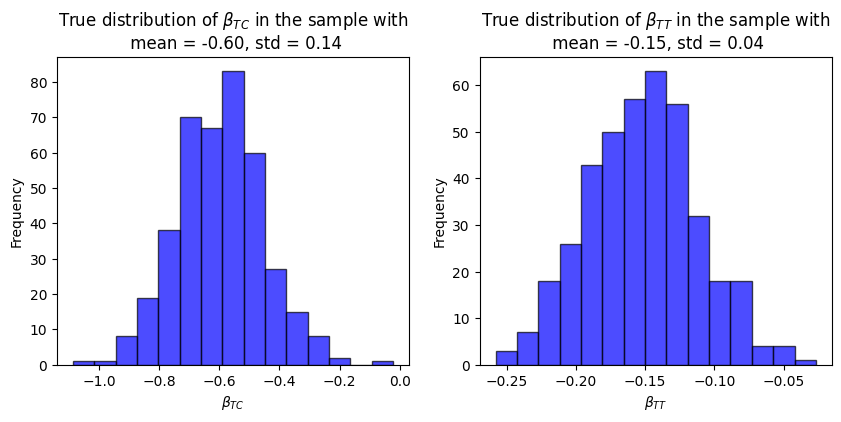

In [6]:
# Verify the distribution of beta_tc and beta_tt using a plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(beta_tcn, bins=15, color='blue', alpha=0.7, edgecolor='black')
ax[0].set_title(f'True distribution of $\\beta_{{TC}}$ in the sample with\n mean = {np.mean(beta_tcn):.2f}, std = {np.std(beta_tcn):.2f}')
ax[1].hist(beta_ttn, bins=15, color='blue', alpha=0.7, edgecolor='black')
ax[1].set_title(f'True distribution of $\\beta_{{TT}}$ in the sample with\n mean = {np.mean(beta_ttn):.2f}, std = {np.std(beta_ttn):.2f}')

ax[0].set_xlabel('$\\beta_{TC}$')
ax[1].set_xlabel('$\\beta_{TT}$')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
plt.show()

#### Compute the choices using the true DGP

In [7]:
# Compute the utilities given the DGP
df['V1'] = asc_1 + beta_tc * df['TC1'] + beta_tt * df['TT1'] 
df['V2'] = asc_2 + beta_tc * df['TC2'] + beta_tt * df['TT2']

# Add the error terms
df['epsilon1'] = np.random.gumbel(size=len(df))
df['epsilon2'] = np.random.gumbel(size=len(df))

# Compute the total utility
df['U1'] = df['V1'] + df['epsilon1']
df['U2'] = df['V2'] + df['epsilon2']

# Identify the chosen alternative
df['CHOICE'] = np.nan
df.loc[df['U1'] > df['U2'], 'CHOICE'] = 1
df.loc[df['U2'] > df['U1'], 'CHOICE'] = 2

# Convert the chosen alternative to an integer (optional)
df['CHOICE'] = df['CHOICE'].astype(int)

# Save the data in a csv file
data_path =  Path(f'data/synthetic_VTTdata_tutorial3.dat')
df[['RESP','TC1', 'TT1', 'TC2', 'TT2','CHOICE']].to_csv(data_path, sep=',', index=False)

# Show the first rows
df.head()
# df.value_counts('CHOICE')

CHOICE
2    2309
1    1691
Name: count, dtype: int64

`--> We have created a data set in which the DGP is linear-additive Panel RUM-MXL`<br>

### 2. Recovery of the model parameters
Now, let's have a look what happens if we estimate a discrete choice model that **perfectly** aligns with the DGP. When we do so, we expect we are able to accurately recover the true parameters.

#### Create a biogeme database in wide format

In [8]:
# Define the Biogeme database object
biodata = db.Database('synthetic_VTTdata_tutorial3', df[['RESP','TC1', 'TT1', 'TC2', 'TT2','CHOICE']])

# Tell Biogeme which variable is the identifier of the individuals
biodata.panel('RESP')

# Calculate the number of observations per individual
obs_per_ind = biodata.data['RESP'].value_counts().unique()[0]
print(f'Number of observations per individual: {obs_per_ind}')

# Use biogeme's "generateFlatPanelDataFrame to create a wide database in which each row corresponds to one individual
df_wide = biodata.generateFlatPanelDataframe(identical_columns=None)

# Rename the columns, such that they run from columnname_{0} to columnname_{n} 
renumbered_columns = {col: f'{col.split("_")[1]}_{int(col.split("_")[0])-1}' if len(col.split("_")) == 2 else col for col in df_wide.columns}

# Rename the columns using the dictionary
df_wide.rename(columns=renumbered_columns, inplace=True)

# Create Biogeme database object
biodata_wide = db.Database('synthetic_VTTdata_tutorial3_wide', df_wide)
biodata_wide.data.head()

/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/biogeme/tools.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_biogroups'] = (df[column] != df[column].shift(1)).cumsum()
/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/biogeme/tools.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_biogroups'], inplace=True)


Number of observations per individual: 10


,CHOICE_0,TC1_0,TC2_0,TT1_0,TT2_0,CHOICE_1,TC1_1,TC2_1,TT1_1,TT2_1,CHOICE_2,TC1_2,TC2_2,TT1_2,TT2_2,CHOICE_3,TC1_3,TC2_3,TT1_3,TT2_3,CHOICE_4,TC1_4,TC2_4,TT1_4,TT2_4,CHOICE_5,TC1_5,TC2_5,TT1_5,TT2_5,CHOICE_6,TC1_6,TC2_6,TT1_6,TT2_6,CHOICE_7,TC1_7,TC2_7,TT1_7,TT2_7,CHOICE_8,TC1_8,TC2_8,TT1_8,TT2_8,CHOICE_9,TC1_9,TC2_9,TT1_9,TT2_9
RESP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,5,7,25,35,2,8,5,20,40,1,6,6,20,40,2,7,5,35,25,2,6,6,40,25,1,8,4,25,35,1,4,8,30,30,2,4,8,35,20,2,5,7,40,20,2,7,4,30,30
2,1,7,4,30,30,2,5,7,40,20,1,4,8,30,30,2,8,4,25,35,2,4,8,35,20,2,7,5,35,25,1,6,6,20,40,1,8,5,20,40,1,5,7,25,35,2,6,6,40,25
3,2,7,4,30,30,2,5,7,40,20,1,4,8,35,20,2,4,8,30,30,2,8,4,25,35,2,6,6,40,25,1,6,6,20,40,1,8,5,20,40,1,5,7,25,35,2,7,5,35,25
4,1,4,8,30,30,2,7,4,30,30,2,5,7,40,20,2,4,8,35,20,2,8,4,25,35,1,6,6,20,40,2,7,5,35,25,2,6,6,40,25,1,8,5,20,40,1,5,7,25,35
5,2,7,4,30,30,2,5,7,40,20,2,4,8,35,20,1,4,8,30,30,1,8,4,25,35,2,7,5,35,25,1,6,6,20,40,2,8,5,20,40,1,5,7,25,35,2,6,6,40,25


#### Estimate the discrete choice model that does capture the panel structure
The true DGP is a linear-additive Panel RUM-MXL. Therefore, we first estimate this model.<br>
Note that estimating this model may take a couple of minutes.

We define the model specification.

In [13]:
# Give the model a name
model_name = 'Panel RUM-MXL model with normally distributed parameters'

# Parameters definition enabling the construction of random parameters
ASC1       = Beta('ASC1',         0, None, None, 1)
ASC2       = Beta('ASC2',         0, None, None, 0)
mu_tc      = Beta('mu_tc',     -0.1, None, None, 0)    
mu_tt      = Beta('mu_tt',     -0.1, None, None, 0)    
sigma_tc   = Beta('sigma_tc ',  0.1, None, None, 0)
sigma_tt   = Beta('sigma_tt ',  0.1, None, None, 0)

# Construction of random parameters   
B_tc_rnd = mu_tc   + sigma_tc   * bioDraws('B_tc_rnd', 'NORMAL_HALTON2')
B_tt_rnd = mu_tt   + sigma_tt   * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions
# Note that we use list comprehension to create a list of utility functions for all observations of an individual 
V1 = [(ASC1 + B_tc_rnd * Variable(f'TC1_{q}') + B_tt_rnd * Variable(f'TT1_{q}')) for q in range(obs_per_ind)]
V2 = [(ASC2 + B_tc_rnd * Variable(f'TC2_{q}') + B_tt_rnd * Variable(f'TT2_{q}')) for q in range(obs_per_ind)]

# Create a dictionary to list the utility functions with the numbering of alternatives
# Note that we use list comprehension to create a list of dictionaries
V = [{1: V1[q], 2: V2[q]} for q in range(obs_per_ind)]
           
# Create a dictionary to describe the availability conditions of each alternative
av = {1:1, 2:1}

We estimate the model and print the results.

In [10]:
# Estimate the model

# The conditional probability of the chosen alternative is a logit
condProb = [models.loglogit(V[q], av, Variable(f'CHOICE_{q}')) for q in range(obs_per_ind)] 

# Take the product of the conditional probabilities
condprobIndiv = exp(bioMultSum(condProb))   # exp to convert from logP to P again

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condprobIndiv)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata_wide , LL)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name
                                
# Compute the null loglikelihood for reporting
# Note that we need to compute it manually, as biogeme does not do this for panel data
biogeme.nullLogLike = len(biodata_wide.data)*np.log(1/2)*obs_per_ind

# Estimate the parameters and print the results
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            ASC2           mu_tc           mu_tt       sigma_tc        sigma_tt      Function    Relgrad   Radius      Rho      
    0               0            -0.1            -0.1             0.1             0.1      2.1e+03       0.96        5   -0.058    - 
    1               0            -0.1            -0.1             0.1             0.1      2.1e+03       0.96      2.5   -0.094    - 
    2               0            -0.1            -0.1             0.1             0.1      2.1e+03       0.96      1.2    -0.12    - 
    3               0            -0.1            -0.1             0.1             0.1      2.1e+03       0.96     0.62    -0.14    - 
    4               0            -0.1            -0.1             0.1             0.1      2.1e+03       0.96     0.31    -0.13    - 
    5               

Results for model Panel MXL normally distributed paratemers
Nbr of parameters:		5
Sample size:			400
Excluded data:			0
Null log likelihood:		-2772.589
Final log likelihood:		-1589.584
Likelihood ratio test (null):		2366.009
Rho square (null):			0.427
Rho bar square (null):			0.425
Akaike Information Criterion:	3189.169
Bayesian Information Criterion:	3209.126

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC2       0.541334      0.045267    11.958698  0.000000e+00
mu_tc     -0.562922      0.020148   -27.938864  0.000000e+00
mu_tt     -0.151698      0.005330   -28.462114  0.000000e+00
sigma_tc   0.074786      0.033569     2.227868  2.588931e-02
sigma_tt  -0.038856      0.007038    -5.520478  3.380786e-08


`Based on the above estimation results, we can make a couple of observations:`<br><br>
`1. The true parameters are recovered well. The estimated parameters are close to the true values, i.e. withint est ± 1.96 * S.E.`<br><br>
`2. The standard errors are fairly small, which is expected given the sample size.`<br><br>
`3. The model seems properly converged, as we see a descent rho square and no suspiciously large S.E. or parameter estimates.`


### 3. The effect of ignoring the panel structure
Now we are going to estimate a linear-additive RUM-MNL model. The utility function of this model is well specified (i.e. it matches the true DGP). But the MNL model does not account for panel structures. That is, it cannot see that *N* individuals made *T* choices. Instead, it treats every observation as a new independent data point. Hence, it ignores the fact that individuals tastes are correlated across choice observations.

#### Estimate a linear-additive RUM-MNL model (i.e. a model that does not capture the panel structure)

In [11]:
# Define the Biogeme database object
biodata = db.Database('synthetic_VTTdata_tutorial4', df[['RESP','TC1', 'TT1', 'TC2', 'TT2','CHOICE']])

# We create Variable objects for each of the variables in the data set that we want to use in the model
TT1  = Variable('TT1')
TC1  = Variable('TC1')
TT2  = Variable('TT2')
TC2  = Variable('TC2')
CHOICE = Variable('CHOICE')

# Define the parameters to be estimated
ASC1 = Beta('ASC1', 0, None, None, 1)
ASC2 = Beta('ASC2', 0, None, None, 0)
B_TT = Beta('B_TT', 0, None, None, 0)
B_TC = Beta('B_TC', 0, None, None, 0)

# Define the utility functions
V1 = ASC1 + B_TT * TT1 + B_TC * TC1
V2 = ASC2 + B_TT * TT2 + B_TC * TC2

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V1, 2: V2}
    
# Create a dictionary called av to describe the availability conditions of each alternative, where 1 indicates that the alternative is available, and 0 indicates that the alternative is not available.
av = {1: 1, 2: 1} 

# Define the choice model: The function models.logit() computes the MNL choice probabilities of the chosen alternative given the V. 
prob = models.logit(V, av, CHOICE)

# Define the log-likelihood   
LL = log(prob)

# Create the Biogeme object containing the object database and the formula for the contribution to the log-likelihood of each row using the following syntax:
biogeme = bio.BIOGEME(biodata, LL)

# The following syntax passes the name of the model:
model_name = 'MNL model'
biogeme.modelName = model_name

# Some object settings regarding whether to save the results and outputs 
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False

# Syntax to calculate the null log-likelihood. The null-log-likelihood is used to compute the rho-square 
biogeme.calculateNullLoglikelihood(av)

# This line starts the estimation and returns the results object.
results_MNL = biogeme.estimate()

# Print the estimation statistics
print(results_MNL.short_summary())

# Get the results in a pandas table
beta_hat_MNL = results_MNL.getEstimatedParameters()
print(beta_hat_MNL)

File biogeme.toml has been parsed. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            ASC2            B_TC            B_TT     Function    Relgrad   Radius      Rho      
    0            0.31           -0.39            -0.1      1.7e+03       0.87    1e+02      1.1   ++ 
    1            0.46           -0.51           -0.13      1.6e+03       0.14    1e+03      1.1   ++ 
    2             0.5           -0.54           -0.14      1.6e+03     0.0064    1e+04        1   ++ 
    3             0.5           -0.54           -0.14      1.6e+03    1.6e-05    1e+05        1   ++ 
    4             0.5           -0.54           -0.14      1.6e+03    1.2e-10    1e+05        1   ++ 


Results for model MNL model
Nbr of parameters:		3
Sample size:			4000
Excluded data:			0
Null log likelihood:		-2772.589
Final log likelihood:		-1609.389
Likelihood ratio test (null):		2326.4
Rho square (null):			0.42
Rho bar square (null):			0.418
Akaike Information Criterion:	3224.777
Bayesian Information Criterion:	3243.659

         Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC2  0.502652      0.045859    10.960866           0.0
B_TC -0.543333      0.018170   -29.902664           0.0
B_TT -0.141623      0.004033   -35.113796           0.0


In [12]:
# Compute the ratio of the standard errors for comparison
ratio_SE = beta_hat['Rob. Std err'][0:3].values/beta_hat_MNL['Rob. Std err'].values

# Show in a dataframe
pd.DataFrame(ratio_SE, columns=['Ratio of standard errors'], index=beta_hat_MNL.index)

,Ratio of standard errors
ASC2,0.987094
B_TC,1.108876
B_TT,1.321472


`--> We can make a couple of observations:`<br><br>
`1. The standard errors of the MNL model are smaller than those from the Panel MXL model (except for the ASC). This result was to be expected since the MNL model overestimates the number of iid data points in the data set because it is blind to the panel structure.`<br><br>
`2. The estimates of the MNL model seem pretty okay. One reason why we do not see more pronounced bias in th estimates is that the normal distribution is symmetric. But more careful inspection shows that B_tt is actually biased`<br><br>
`3. The Final log-likelihood of the Panel MXL model is higher that of the MNL model. This is expected because the former is matches the true DGP, while the latter does not`
